<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/wind_blade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wind Turbine Blade Structural Health Monitoring

### 1. Summary

This notebook provides a complete workflow for downloading, processing, and analyzing vibration data from a benchmark study on a small-scale wind turbine blade. The goal is to compare the response of a healthy blade with a blade that has a significant crack, demonstrating a fundamental approach to vibration-based structural health monitoring (SHM).

The data is sourced from the Zenodo repository associated with the following publication:

> Ou, Y., Tatsis, K. E., Dertimanis, V. K., Spiridonakos, M. D., & Chatzi, E. N. (2020). Vibration-based monitoring of a small-scale wind turbine blade under varying climate conditions. Part I: An experimental benchmark. *Structural Control and Health Monitoring*, e2660.

### 2. Core Functionality

This notebook specifically focuses on two key scenarios at **0°C**:
* **Case R**: The healthy, undamaged (nominal) blade.
* **Case L**: The blade with the most severe crack damage.

The workflow performs the following steps:
1.  **Targeted Download**: Efficiently downloads only the necessary data for Cases R and L from Zenodo, avoiding the full 80 GB dataset.
2.  **Data Loading**: Reads the raw time-series data from the `.lvm` (LabVIEW Measurement) files.
3.  **Signal Visualization**: Generates plots for the primary `sine_sweep` excitation signal and the corresponding eight acceleration sensor responses in both the **time domain** and the **frequency domain (spectra)**.

### 3. Potential Extensions & Future Work

This notebook is designed to be a starting point. Its functionality can be significantly expanded to create a more powerful and interactive data downloading tool. Possible improvements include:

* **Dynamic Case and Temperature Selection**: Modify the code to allow the user to select any combination of damage case (e.g., 'A', 'C', 'H', 'K') and temperature (from -15°C to +40°C) using dropdown menus or input fields. The notebook would then dynamically generate the download links and file paths.
* **Comprehensive Data Download**: Consider using the `zenodo_get` function as an option for downloading, as the wget function sometimes fails.
* **Excitation Signal Selection**: Allow the user to choose which excitation signal to analyze from the available files, such as the `sine_sweep.lvm` or any of the available measurements.

In [1]:
# @title 1. Install Necessary Packages
# @markdown This cell installs the required Python libraries:
# @markdown - `lvm_read`: To read the LabVIEW Measurement files (.lvm).
!pip install -q lvm_read

print("✅ Installation complete.")

✅ Installation complete.


In [2]:
# @title 2. Download and Unzip Specific Cases
# @markdown This cell downloads the two specified zip files for **Case R (0°C)** and
# @markdown **Case L (0°C)** directly and unzips them into a folder named `/content/dataset/`.
import os

# URLs provided by the user
url_r = "https://zenodo.org/records/3229743/files/Case_R_(+00).zip?download=1"
url_l = "https://zenodo.org/records/3229743/files/Case_L_(+00).zip?download=1"

# Output filenames
zip_file_r = "Case_R_00.zip"
zip_file_l = "Case_L_00.zip"
output_directory = "/content/dataset/"

# Download Case R
print(f"Downloading {zip_file_r}...")
!wget -q -O {zip_file_r} "{url_r}"
print("✅ Download complete.")

# Download Case L
print(f"\nDownloading {zip_file_l}...")
!wget -q -O {zip_file_l} "{url_l}"
print("✅ Download complete.")

# Unzip the downloaded files
if os.path.exists(zip_file_r) and os.path.exists(zip_file_l):
    print(f"\nUnzipping files to {output_directory}...")
    !unzip -q {zip_file_r} -d {output_directory}
    !unzip -q {zip_file_l} -d {output_directory}
    print(f"✅ Both datasets successfully unzipped.")
else:
    print("❌ Error: One or both ZIP files not found after download.")

✅ Download complete.

✅ Download complete.

Unzipping files to /content/dataset/...
✅ Both datasets successfully unzipped.


In [3]:
# @title 3. Read LVM Data for Cases R and L (0°C)
# @markdown This cell imports the necessary libraries and reads the data from the
# @markdown `sine_sweep.lvm` files for the nominal case (R) and the worst crack
# @markdown case (L), both at 0 degrees Celsius.
import os
import numpy as np
import matplotlib.pyplot as plt
import lvm_read

# --- Define file paths ---
# The data for 0 degrees is in the '_(+00)' folders.
# We will use the first set of measurements in the '_1' subfolders.
# We assume 'sine_sweep.lvm' is the desired file for plotting excitation and response.
path_r = os.path.join(output_directory, "Case_R_(+00)/Case_R_(+00)_1/sine_sweep.lvm")
path_l = os.path.join(output_directory, "Case_L_(+00)/Case_L_(+00)_1/sine_sweep.lvm")

# --- Load the LVM files ---
try:
    lvm_r = lvm_read.read(path_r)
    print(f"Successfully loaded Case R data from: {path_r}")
    lvm_l = lvm_read.read(path_l)
    print(f"Successfully loaded Case L data from: {path_l}")

    # --- Extract Data for Case R ---
    data_r = lvm_r[0]['data']
    time_r = data_r[:, 0]
    accel_r = data_r[:, 1:9]   # Channels Ch1-Ch8 are accelerometers
    excit_r = data_r[:, 13]    # Channel 'force' is the excitation

    # --- Extract Data for Case L ---
    data_l = lvm_l[0]['data']
    time_l = data_l[:, 0]
    accel_l = data_l[:, 1:9]
    excit_l = data_l[:, 13]

    print("\n✅ Data extraction complete.")

except FileNotFoundError as e:
    print(f"❌ Error: Could not find a file. Make sure the download and unzip steps were successful. Details: {e}")

Successfully loaded Case R data from: /content/dataset/Case_R_(+00)/Case_R_(+00)_1/sine_sweep.lvm
Successfully loaded Case L data from: /content/dataset/Case_L_(+00)/Case_L_(+00)_1/sine_sweep.lvm

✅ Data extraction complete.


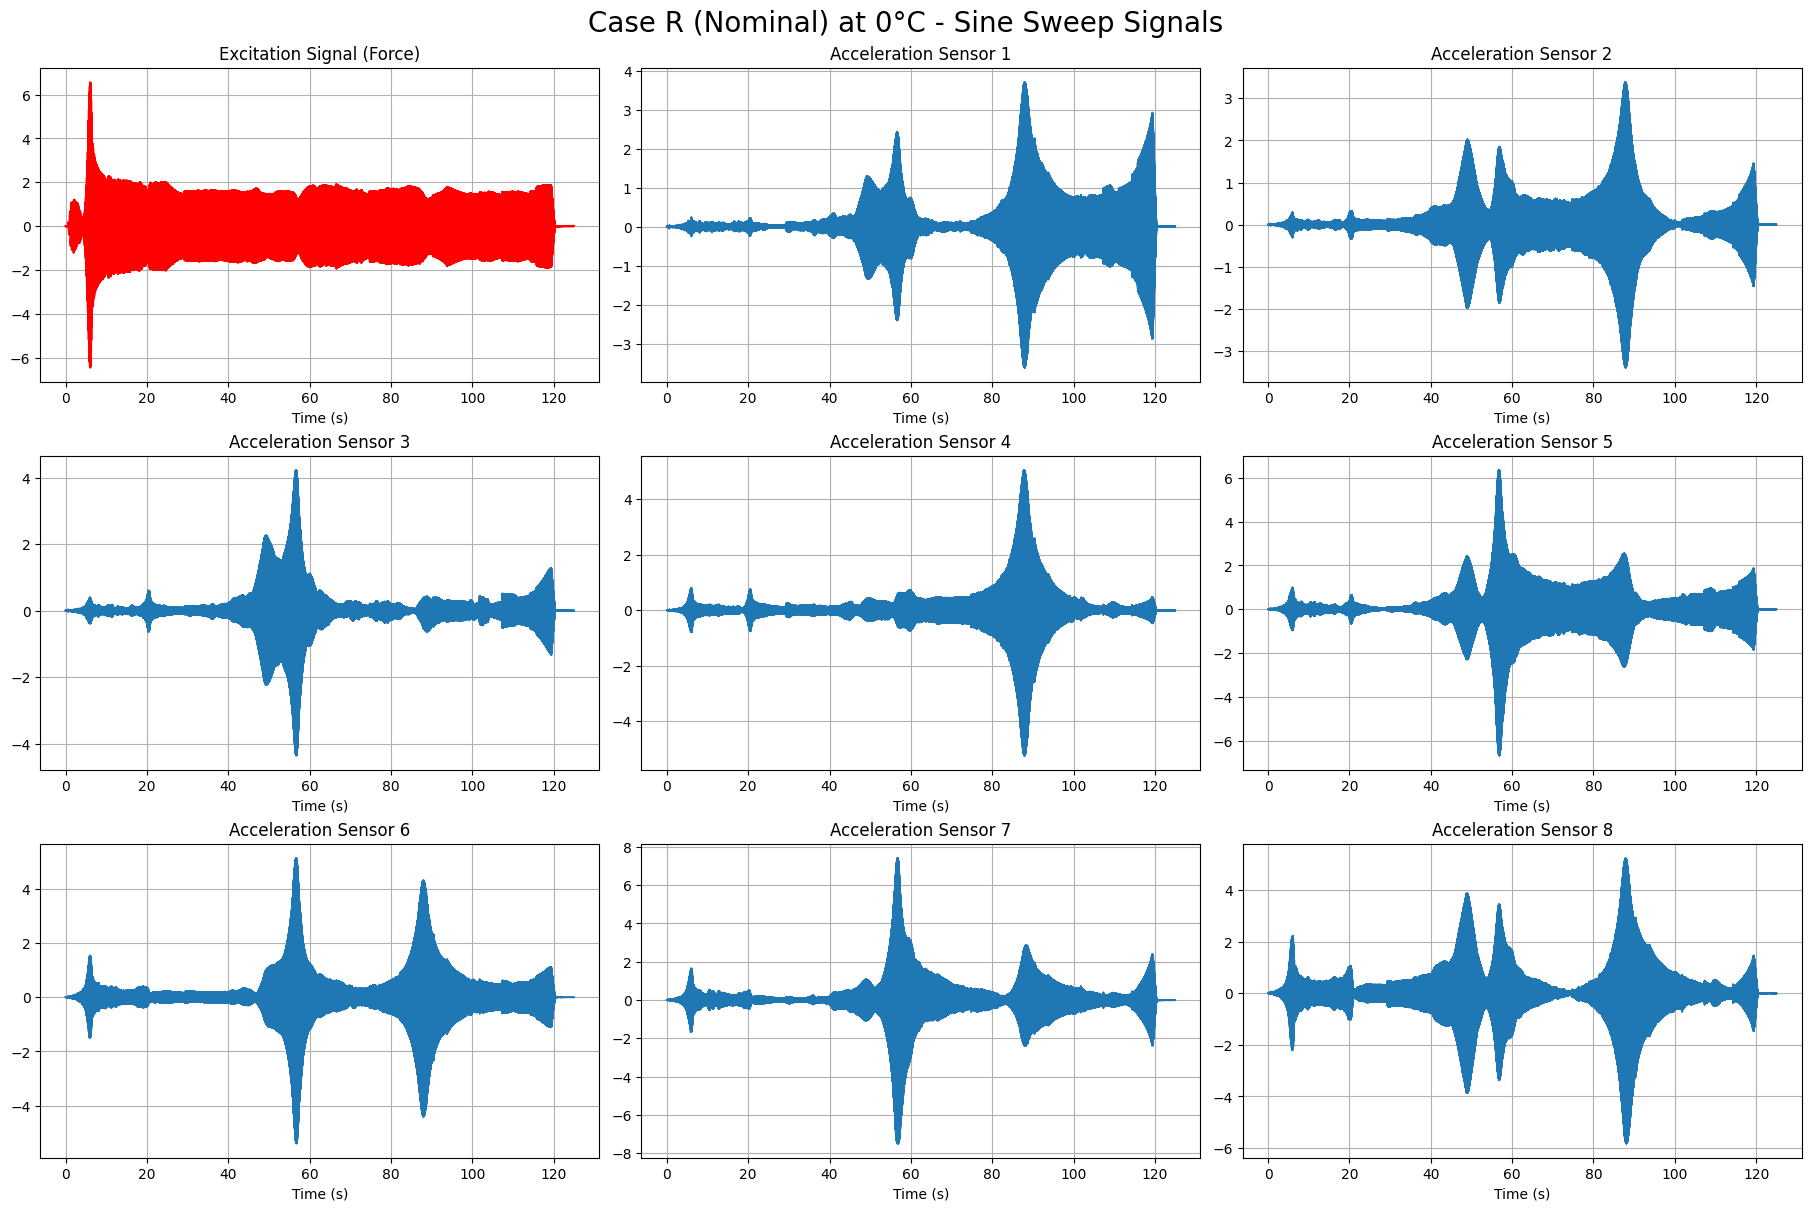

In [4]:
# @title 4. Plot Signals for Case R (Nominal, 0°C)
# @markdown This cell plots the excitation signal and the 8 acceleration signals
# @markdown for the nominal case (R).
if 'lvm_r' in locals():
    # Create a 3x3 grid for the 9 plots
    fig_r, axs_r = plt.subplots(3, 3, figsize=(18, 12), constrained_layout=True)
    fig_r.suptitle('Case R (Nominal) at 0°C - Sine Sweep Signals', fontsize=20)

    # Flatten the axes array for easy iteration
    axs_r = axs_r.flatten()

    # 1. Plot Excitation Signal
    axs_r[0].plot(time_r, excit_r, color='red')
    axs_r[0].set_title('Excitation Signal (Force)')
    axs_r[0].set_xlabel('Time (s)')
    axs_r[0].grid(True)

    # 2. Plot the 8 Acceleration Signals
    for i in range(8):
        axs_r[i+1].plot(time_r, accel_r[:, i])
        axs_r[i+1].set_title(f'Acceleration Sensor {i+1}')
        axs_r[i+1].set_xlabel('Time (s)')
        axs_r[i+1].grid(True)

    plt.show()
else:
    print("❌ Case R data not loaded. Please run the previous cells first.")

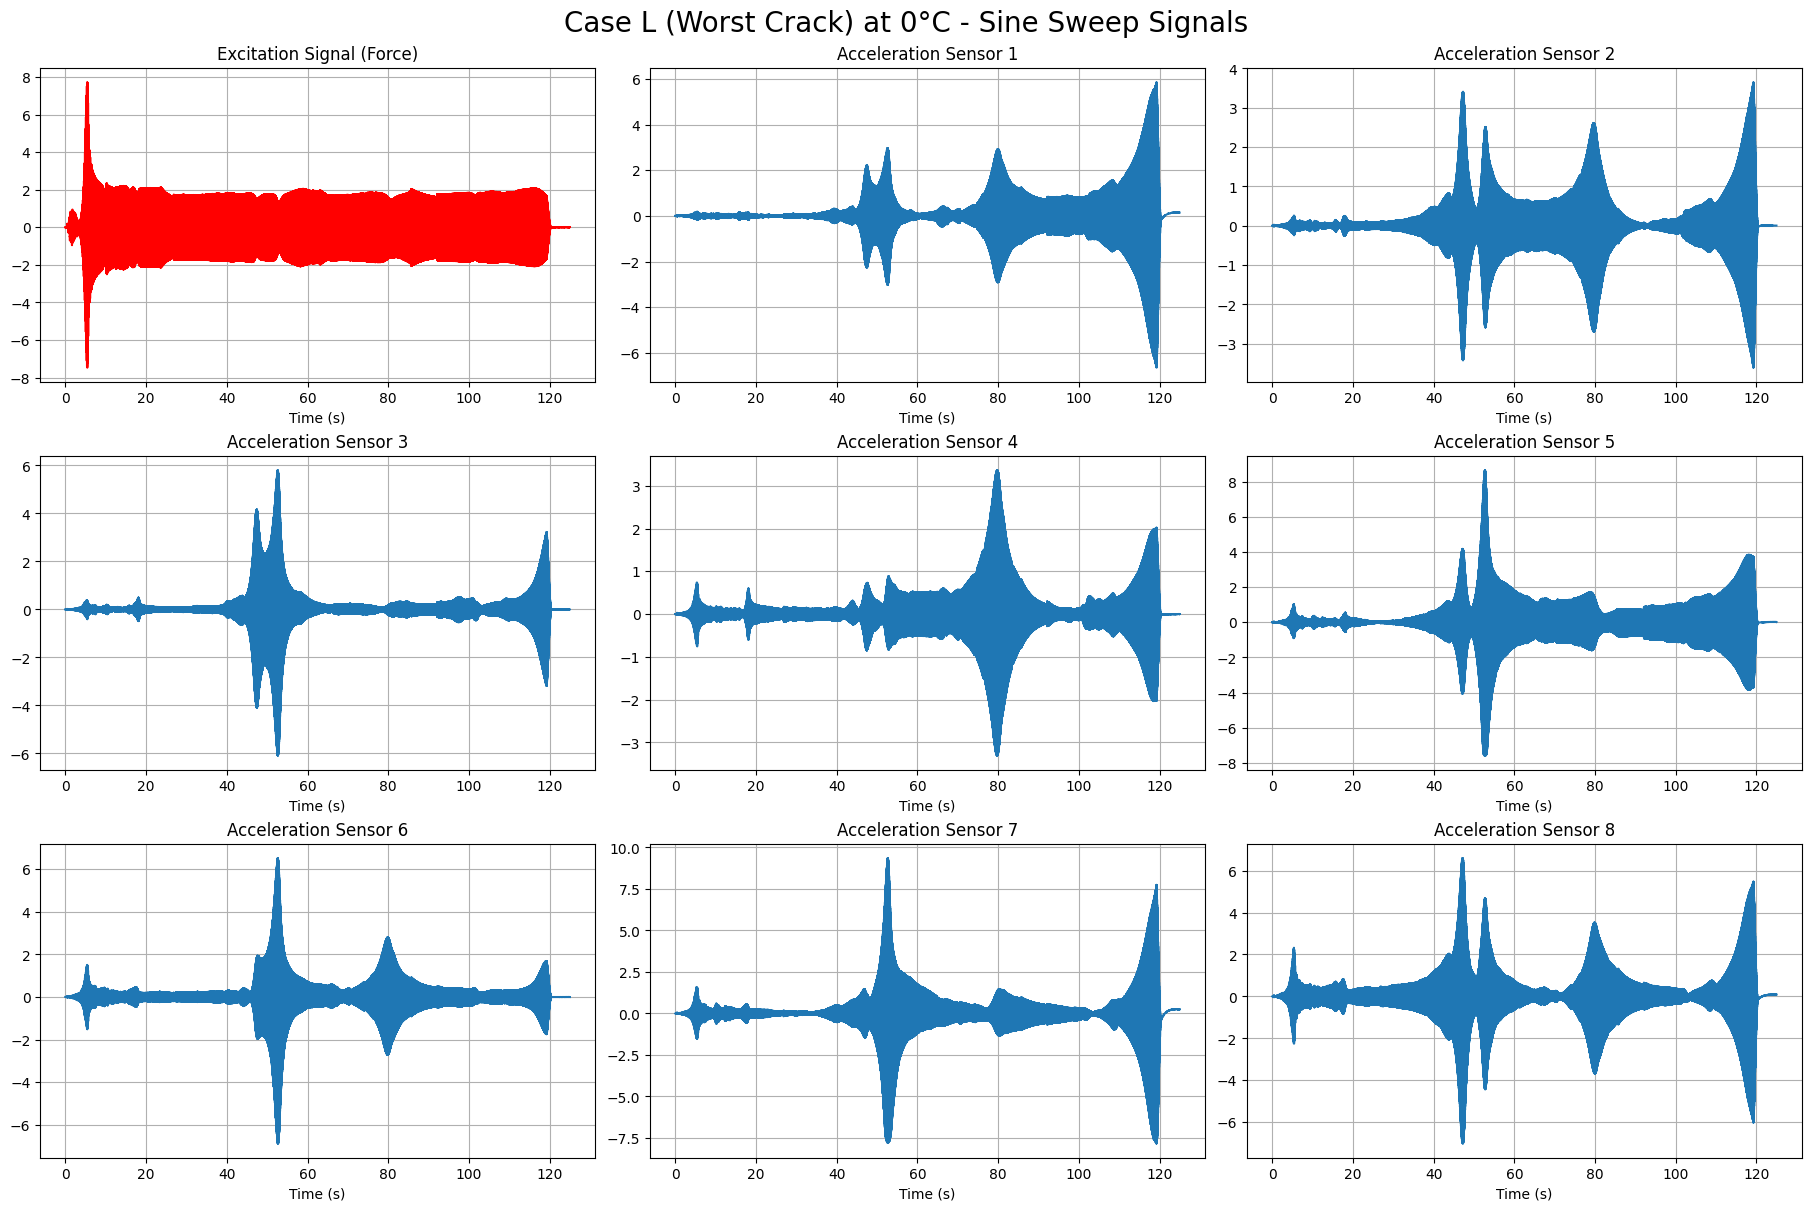

In [5]:
# @title 5. Plot Signals for Case L (Worst Crack, 0°C)
# @markdown This cell plots the excitation signal and the 8 acceleration signals
# @markdown for the worst crack case (L).
if 'lvm_l' in locals():
    # Create a 3x3 grid for the 9 plots
    fig_l, axs_l = plt.subplots(3, 3, figsize=(18, 12), constrained_layout=True)
    fig_l.suptitle('Case L (Worst Crack) at 0°C - Sine Sweep Signals', fontsize=20)

    # Flatten the axes array for easy iteration
    axs_l = axs_l.flatten()

    # 1. Plot Excitation Signal
    axs_l[0].plot(time_l, excit_l, color='red')
    axs_l[0].set_title('Excitation Signal (Force)')
    axs_l[0].set_xlabel('Time (s)')
    axs_l[0].grid(True)

    # 2. Plot the 8 Acceleration Signals
    for i in range(8):
        axs_l[i+1].plot(time_l, accel_l[:, i])
        axs_l[i+1].set_title(f'Acceleration Sensor {i+1}')
        axs_l[i+1].set_xlabel('Time (s)')
        axs_l[i+1].grid(True)

    plt.show()
else:
    print("❌ Case L data not loaded. Please run the previous cells first.")

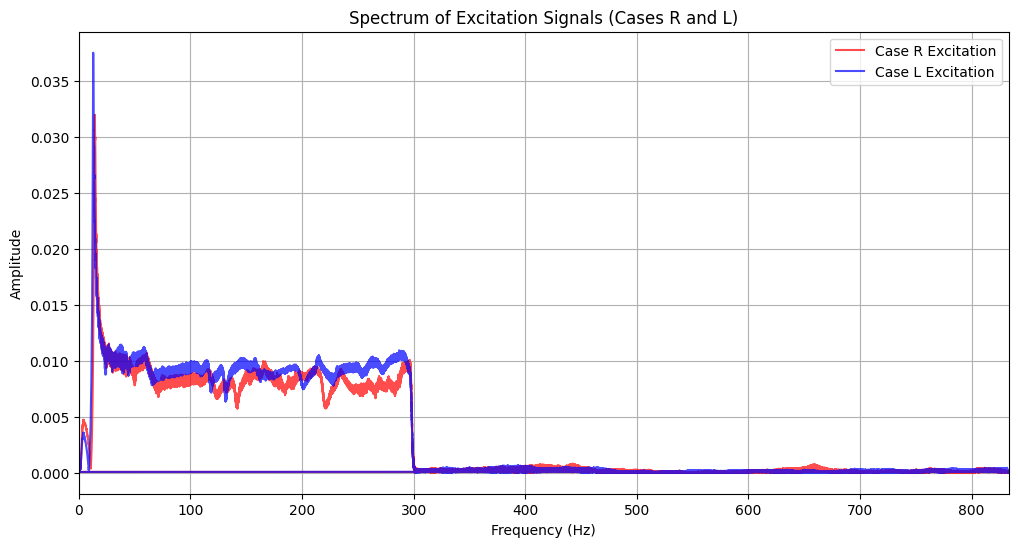

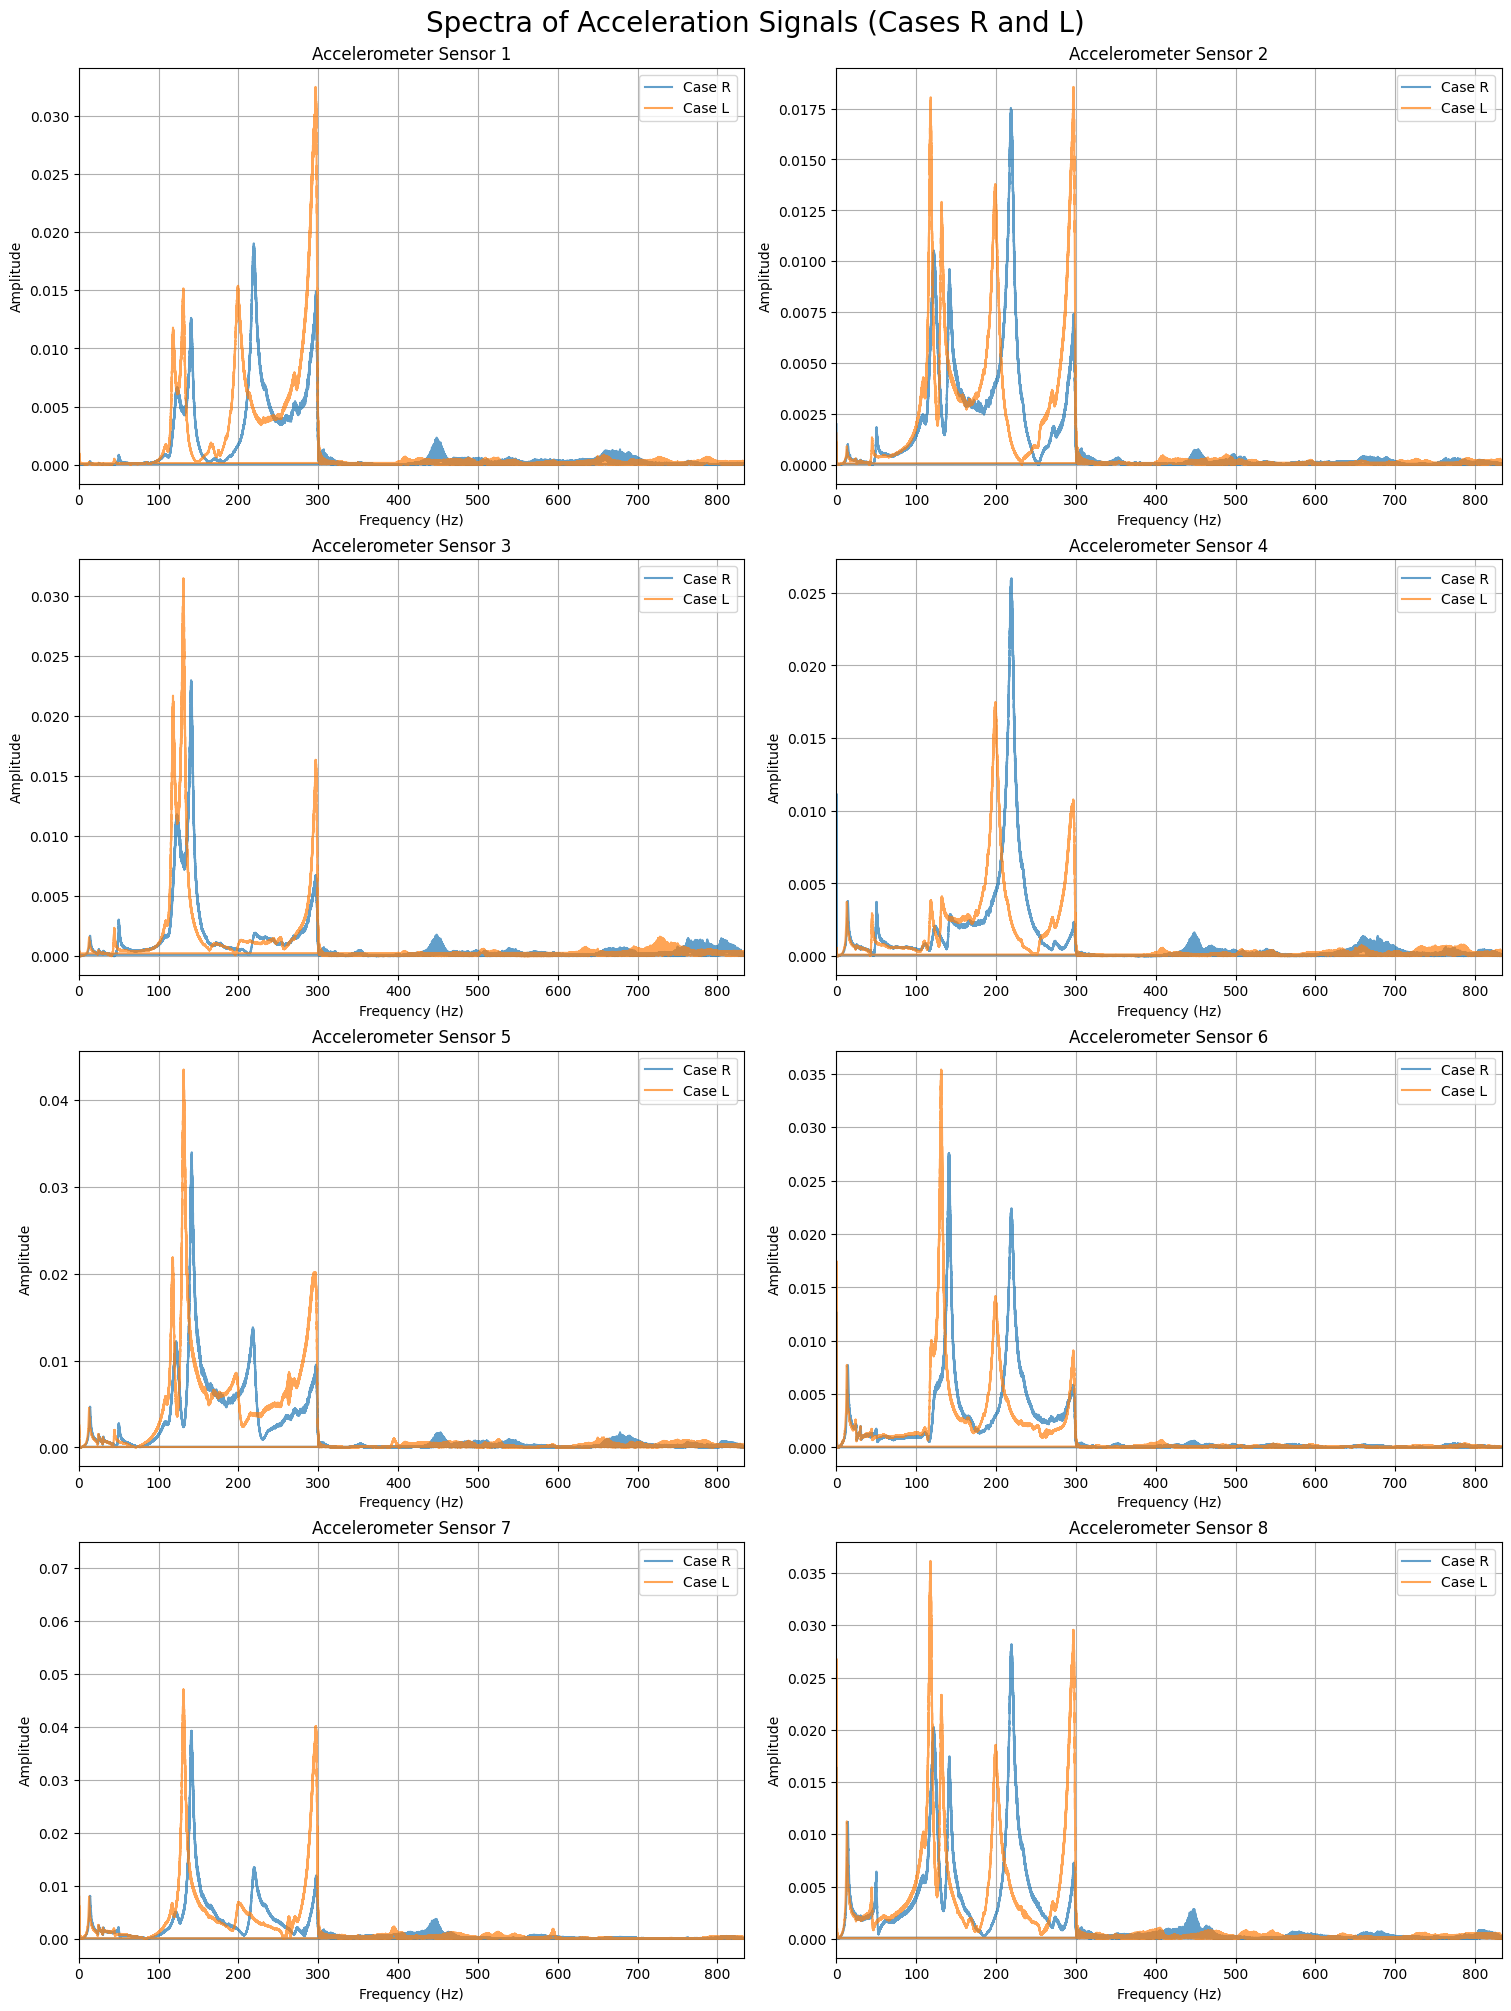

In [6]:
# prompt: generate the spectrum of the signals in R and L. plot in the same graph (grouped by types, R and L)

import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

# Calculate the sampling frequency (assuming uniform time steps)
# Use the first file's time array to calculate sampling frequency
sampling_rate = 1 / (time_r[1] - time_r[0]) # Hz

# Calculate the frequency spectrum for Excitation and Accelerometers for Case R
if 'excit_r' in locals() and 'accel_r' in locals():
    # Spectrum of Excitation (R)
    n_r_excit = len(excit_r)
    yf_r_excit = fft(excit_r)
    xf_r_excit = fftfreq(n_r_excit, 1/sampling_rate)

    # Spectrum of Accelerometers (R)
    n_r_accel = accel_r.shape[0]
    yf_r_accel = fft(accel_r, axis=0)
    xf_r_accel = fftfreq(n_r_accel, 1/sampling_rate)

# Calculate the frequency spectrum for Excitation and Accelerometers for Case L
if 'excit_l' in locals() and 'accel_l' in locals():
    # Spectrum of Excitation (L)
    n_l_excit = len(excit_l)
    yf_l_excit = fft(excit_l)
    xf_l_excit = fftfreq(n_l_excit, 1/sampling_rate)

    # Spectrum of Accelerometers (L)
    n_l_accel = accel_l.shape[0]
    yf_l_accel = fft(accel_l, axis=0)
    xf_l_accel = fftfreq(n_l_accel, 1/sampling_rate)


# Plotting the spectra
if 'xf_r_excit' in locals() and 'xf_l_excit' in locals():
    # Plotting Excitation Spectra
    plt.figure(figsize=(12, 6))
    plt.plot(xf_r_excit, 2.0/n_r_excit * np.abs(yf_r_excit), label='Case R Excitation', color='red', alpha=0.7)
    plt.plot(xf_l_excit, 2.0/n_l_excit * np.abs(yf_l_excit), label='Case L Excitation', color='blue', alpha=0.7)
    plt.title('Spectrum of Excitation Signals (Cases R and L)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, sampling_rate / 2) # Plot only positive frequencies
    plt.show()

if 'xf_r_accel' in locals() and 'xf_l_accel' in locals():
    # Plotting Accelerometer Spectra (grouped by sensor, then case)
    fig_accel, axs_accel = plt.subplots(4, 2, figsize=(15, 20), constrained_layout=True)
    fig_accel.suptitle('Spectra of Acceleration Signals (Cases R and L)', fontsize=20)

    axs_accel = axs_accel.flatten()

    for i in range(8):
        axs_accel[i].plot(xf_r_accel, 2.0/n_r_accel * np.abs(yf_r_accel[:, i]), label='Case R', alpha=0.7)
        axs_accel[i].plot(xf_l_accel, 2.0/n_l_accel * np.abs(yf_l_accel[:, i]), label='Case L', alpha=0.7)
        axs_accel[i].set_title(f'Accelerometer Sensor {i+1}')
        axs_accel[i].set_xlabel('Frequency (Hz)')
        axs_accel[i].set_ylabel('Amplitude')
        axs_accel[i].grid(True)
        axs_accel[i].legend()
        axs_accel[i].set_xlim(0, sampling_rate / 2) # Plot only positive frequencies

    plt.show()
else:
    print("❌ Spectrum data for accelerometers not available. Please ensure data loading was successful.")
